In [1]:
import time
from typing import Iterable

import np as np
import torch
from cgtasknet.tasks.reduce import ReduceTaskCognitive
from sklearn.cluster import KMeans


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
        self, model: torch.nn.Module, tasks: Iterable[ReduceTaskCognitive]
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = None

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for current_task in self._tasks:
            t0 = time.perf_counter()
            self._subgroups_finder.append(0)
            for i in range(number_of_trials):
                inputs, t_outputs, s, out = self._run_trial(current_task)
                self._subgroups_finder[-1] += torch.mean(s, dim=0)
            self._subgroups_finder[-1] /= number_of_trials
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )

    def _run_trial(self, task: ReduceTaskCognitive):
        inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        out, _, s = self._model(inputs)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):

        return self._subgroups_finder

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
)
import matplotlib.pyplot as plt

In [3]:
go_task_list_values = np.linspace(0, 1, 8)

batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.25,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=0.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.25,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=0.25,
            value=go_task_list_values,
        ),
        delay=0.2,
        positive_shift_delay_time=1.5,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=i,
    )
    for i in range(len(tasks))
]

In [5]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 256

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.45),
    tau_ada_inv=1 / 2,
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=80,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        r"..\..\..\models\low_freq\mean_fr_filter_less_v_th_0_45_filter_80\weights\weights_100_N_256_without_square_2999_",
        map_location=device,
    )
)

<All keys matched successfully>

In [22]:
from sklearn.cluster import KMeans

subgroups = EveryTaskSubgroups(model, tasks_sequence)

subgroups.device = device
frequencies = []
for i in range(100):
    print(i)
    subgroups.run(1)
    freq = subgroups.get_frequencies()
    frequencies.append(
        [el.detach().cpu().numpy() if el is not None else None for el in freq]
    )

0
******************** Start
Complete task: 0, time: 0.44384900000000016s
Complete task: 1, time: 0.32573469999999816s
Complete task: 2, time: 0.2890775999999846s
Complete task: 3, time: 0.46691700000002356s
Complete task: 4, time: 0.4526334000000247s
Complete task: 5, time: 0.565148000000022s
Complete task: 6, time: 0.6747538999999847s
Complete task: 7, time: 0.5578715000000329s
Complete task: 8, time: 0.5136061000000041s
Complete task: 9, time: 0.5350258999999937s
Complete task: 10, time: 0.4377470999999673s
Complete task: 11, time: 0.3863424000000464s
1
******************** Start
Complete task: 0, time: 0.3306699999999978s
Complete task: 1, time: 0.6495415000000548s
Complete task: 2, time: 0.38568600000002107s
Complete task: 3, time: 0.34180759999998145s
Complete task: 4, time: 0.8374912999999538s
Complete task: 5, time: 0.449571399999968s
Complete task: 6, time: 0.9932651999999962s
Complete task: 7, time: 0.7809000999999967s
Complete task: 8, time: 0.5115243999999848s
Complete task

In [23]:
type = "save"
if type == "save":
    torch.save(
        frequencies, "data/256_low_freq_filter_20_vth_0_45_filter_80/frequencies"
    )
elif type == "load":
    frequencies = torch.load(
        "data/256_low_freq_filter_20_vth_0_45_filter_80/frequencies"
    )

In [24]:
answers_np = np.array(frequencies).T
answers_np = answers_np.reshape(
    answers_np.shape[-1] * answers_np.shape[-2], answers_np.shape[0]
).T
# indexes = np.where(answers_np.mean(axis=1) > 25)[0]
answers_np = np.concatenate(frequencies).T + 1
# answers_np = answers_np[indexes, :]
answers_np = (answers_np.T / np.sum(answers_np, axis=1)).T
print(answers_np.shape)

(256, 1200)


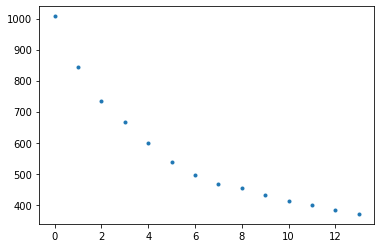

UsageError: Line magic function `%` not found.


In [25]:
X = np.concatenate(frequencies, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 3
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
X = np.concatenate(frequencies, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
X = np.concatenate(frequencies, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
x1 = [
    35,
    46,
    205,
    27,
    39,
    190,
    198,
    134,
    44,
    65,
    124,
    177,
    162,
    175,
    0,
    34,
    114,
    118,
    229,
    224,
    100,
    86,
    6,
    161,
    248,
    223,
    180,
    249,
    130,
    96,
    80,
    218,
    216,
    178,
    246,
    37,
    83,
    209,
    185,
    170,
    43,
    2,
    227,
    228,
    31,
    183,
    237,
    189,
    75,
    188,
    159,
    108,
    150,
    91,
    117,
    85,
    137,
    77,
    142,
    60,
    69,
    187,
    25,
    156,
    54,
    112,
    123,
    133,
    128,
    28,
    19,
    81,
    132,
    78,
    201,
    233,
    144,
    105,
    172,
    242,
    70,
    99,
    169,
    155,
    158,
    24,
    74,
    204,
    113,
    11,
    51,
    145,
    13,
    119,
    154,
    247,
    234,
    126,
    115,
    152,
    200,
    168,
    20,
    109,
    73,
    191,
    239,
    197,
    49,
    47,
    195,
    68,
    235,
    121,
    230,
    30,
    21,
    92,
    222,
    94,
    199,
    32,
    192,
    84,
    203,
    236,
    62,
    252,
    72,
    82,
    208,
    157,
    221,
    226,
    87,
    97,
    1,
    110,
    79,
    253,
    38,
    3,
    238,
    240,
    219,
    14,
    116,
    23,
    8,
    143,
    211,
    18,
    89,
    182,
    207,
    241,
    225,
    220,
    141,
    210,
    103,
    98,
    135,
    120,
    215,
    15,
    166,
    22,
    106,
    48,
    173,
    45,
    9,
    243,
    153,
    174,
    136,
    7,
    129,
    244,
    29,
    254,
    26,
    194,
    95,
    102,
    17,
    88,
    171,
    10,
    101,
    111,
    66,
    212,
    53,
    202,
    196,
    127,
    71,
    41,
    245,
    148,
    176,
    58,
    186,
    147,
    250,
    206,
    213,
    138,
    122,
    181,
    16,
    52,
    160,
    33,
    125,
    165,
    140,
    251,
    151,
    179,
    167,
    131,
    36,
    63,
    40,
    163,
    55,
    5,
    146,
    4,
    232,
    57,
    149,
    76,
    64,
    93,
    42,
    255,
    59,
    139,
    61,
    67,
    104,
    217,
    50,
    12,
    231,
    164,
    193,
    90,
    56,
    214,
    184,
    107,
][::-1]
x1 = x1[-100:]
x2 = [int(el.get_text()) for el in fig.axes[0].get_xticklabels()][-100:]

len((set(x2) & set(x1)))

In [ ]:
x1 = [
    83,
    98,
    137,
    15,
    145,
    100,
    91,
    160,
    224,
    188,
    159,
    54,
    182,
    222,
    46,
    248,
    94,
    45,
    161,
    205,
    40,
    96,
    213,
    59,
    240,
    32,
    135,
    38,
    116,
    162,
    76,
    242,
    56,
    118,
    171,
    79,
    115,
    147,
    163,
    179,
    82,
    42,
    255,
    164,
    155,
    12,
    84,
    185,
    144,
    120,
    157,
    36,
    151,
    27,
    133,
    251,
    154,
    68,
    2,
    87,
    101,
    122,
    57,
    4,
    229,
    92,
    156,
    183,
    203,
    34,
    176,
    49,
    167,
    106,
    207,
    50,
    35,
    107,
    6,
    141,
    123,
    86,
    75,
    146,
    172,
    191,
    139,
    97,
    165,
    226,
    252,
    140,
    253,
    246,
    148,
    180,
    231,
    193,
    190,
    153,
    158,
    211,
    131,
    26,
    108,
    173,
    114,
    230,
    201,
    109,
    80,
    130,
    250,
    208,
    19,
    39,
    71,
    168,
    21,
    28,
    125,
    134,
    192,
    51,
    181,
    209,
    72,
    166,
    196,
    64,
    243,
    197,
    227,
    24,
    244,
    143,
    129,
    20,
    81,
    9,
    195,
    184,
    17,
    198,
    90,
    61,
    241,
    126,
    186,
    225,
    37,
    43,
    63,
    70,
    11,
    55,
    99,
    215,
    245,
    13,
    216,
    233,
    102,
    47,
    132,
    0,
    62,
    152,
    31,
    204,
    103,
    111,
    33,
    8,
    88,
    73,
    1,
    200,
    142,
    48,
    212,
    53,
    119,
    235,
    60,
    149,
    69,
    14,
    236,
    210,
    18,
    66,
    127,
    239,
    124,
    110,
    238,
    150,
    23,
    169,
    74,
    220,
    175,
    25,
    178,
    67,
    104,
    232,
    65,
    112,
    89,
    121,
    217,
    10,
    218,
    105,
    170,
    93,
    199,
    187,
    221,
    249,
    7,
    41,
    206,
    223,
    189,
    77,
    44,
    136,
    237,
    234,
    174,
    228,
    117,
    5,
    113,
    29,
    177,
    247,
    22,
    202,
    78,
    214,
    219,
    30,
    95,
    16,
    52,
    138,
    85,
    128,
    194,
    254,
    58,
    3,
][::-1]
x1 = x1[-100:]
x2 = [int(el.get_text()) for el in fig.axes[0].get_xticklabels()][-100:]

len((set(x2) & set(x1)))

In [ ]:
set([1, 2, 4]) & set([2, 3, 4])

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import matplotlib.cm

%matplotlib inline
distance_mat = pdist(
    X
)  # pdist посчитает нам верхний треугольник матрицы попарных расстояний
Z = hierarchy.linkage(X, "ward")  # linkage — реализация агломеративного алгоритма
fig = plt.figure(figsize=(10, 5))
# ierarchy.set_link_color_palette(([*range(hidden_size)]))
dn = hierarchy.dendrogram(Z, color_threshold=000, distance_sort="descending")

# plt.savefig('dendra.png', dpi=1500)
plt.show()
# plt.close()

In [ ]:
for key, item in dn.items():
    print(key)
    print(item)

In [ ]:
dn

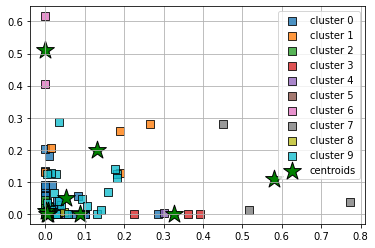

In [28]:
X = np.concatenate(frequencies, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
n_clusters = 10
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.
# 00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [29]:
answers_np = np.array(frequencies)
tv = [answers_np[:, i, :].mean(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


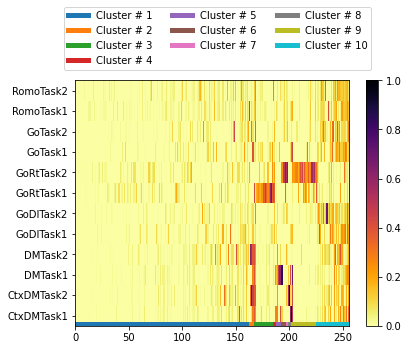

In [30]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

answers_np = np.array(frequencies)
tv = [answers_np[:, i, :].sum(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
sort_indexes = [*range(hidden_size)]
sort_indexes = sort_elemnts_by_another(tv[1], sort_indexes)
tv_sort = np.zeros_like(tv)
clusters = []
for i in range(n_clusters):
    clusters.extend(
        sort_elemnts_by_another(
            np.mean(tv[:, [*np.where(y_km == i)[0]]], axis=0), [*np.where(y_km == i)[0]]
        )
    )
cluster_sizes = []
for i in range(n_clusters):
    cluster_i = [*np.where(y_km == i)[0]]
    cluster_sizes.append(len(cluster_i))
for i in range(n_clusters):
    clusters.extend([*np.where(y_km == i)[0]])
clusters = clusters[::]
for task in range(len(tv)):
    for i in range(hidden_size):
        tv_sort[task, i] = tv[task, clusters[i]]
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="inferno_r", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
cluster_size = 0
colors = ["#EF3B3B", "#233DFB", "#49FF00", "#F333FF", "#BF035B", "#23305F"]
for i in range(0, len(cluster_sizes)):
    plt.plot(
        [cluster_size, cluster_size + cluster_sizes[i]],
        [-0.4, -0.4],
        label=f"Cluster # {i + 1}",
        # c=colors[i],
        linewidth=5,
    )
    # plt.plot([cluster_size ] * 2, [-1, len(tasks_couples)], c='black', linestyle='--', linewidth=.5)
    cluster_size += cluster_sizes[i]
# plt.legend()
# plt.xlim(0, 600)
plt.colorbar()
plt.tight_layout()
legend = plt.legend(bbox_to_anchor=(0.1, 1.02, 1, 0.3), ncol=3)
plt.xlim(0, 256)
plt.savefig(
    "Clusters.eps", format="eps", bbox_extra_artists=(legend,), bbox_inches="tight"
)
plt.savefig("Clusters.png", dpi=1500)

plt.show()
plt.close()

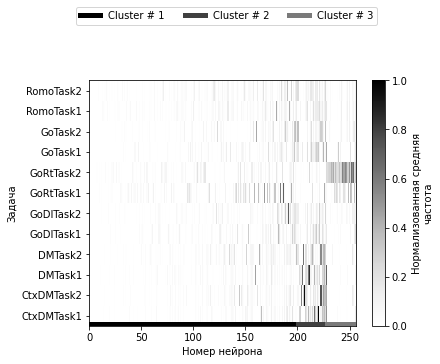

In [27]:
from matplotlib import cm

plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="Greys", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
cluster_size = 0
# colors = ["#EF3B3B", "#233DFB", "#49FF00", "#F333FF", "#BF035B", "#23305F"]
colors = cm.Greys(np.linspace(0, 1, n_clusters + 3))[::-1]
for i in range(0, len(cluster_sizes)):
    plt.plot(
        [cluster_size, cluster_size + cluster_sizes[i]],
        [-0.4, -0.4],
        label=f"Cluster # {i + 1}",
        c=colors[i],
        linewidth=5,
    )
    # plt.plot([cluster_size ] * 2, [-1, len(tasks_couples)], c='black', linestyle='--', linewidth=.5)
    cluster_size += cluster_sizes[i]
# plt.legend()
# plt.xlim(0, 600)
clb = plt.colorbar()
clb.set_label("Нормализованная средняя\nчастота")
plt.tight_layout()
legend = plt.legend(bbox_to_anchor=(0.1, 1.02, 1, 0.3), ncol=3)
plt.xlim(0, 256)
# plt.savefig('Clusters.eps', format='eps', bbox_extra_artists=(legend, ), bbox_inches='tight')
plt.xlabel("Номер нейрона")
plt.ylabel("Задача")
plt.savefig("Clusters.png", dpi=1500, bbox_extra_artists=(legend,), bbox_inches="tight")

plt.show()
plt.close()

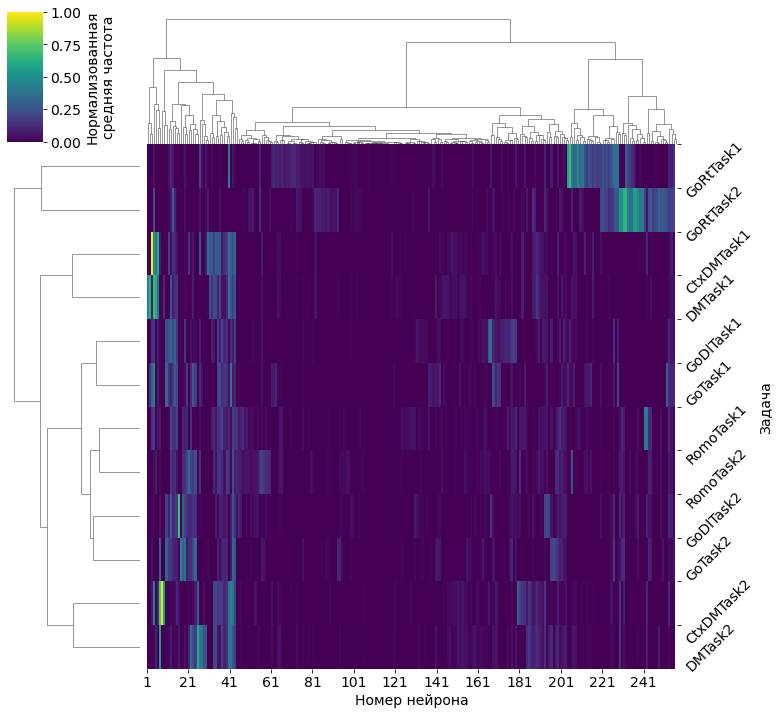

In [37]:
import seaborn as sns

plt.rcParams["font.size"] = 14
X = np.concatenate(frequencies, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
# fig, ax = plt.subplots(111)
tv = [answers_np[:, i, :].mean(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
cg = sns.clustermap(tv, cmap="viridis", method="ward")
# (cg.ax_heatmap.set_yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=45))
sorted_tasks = sorted(tasks)
cg.ax_heatmap.set_yticks(
    np.arange(0, len(tasks)),
    [sorted_tasks[int(el.get_text())] for el in cg.ax_heatmap.get_yticklabels()],
    rotation=45,
)
cg.ax_heatmap.set_xticks(
    np.arange(1, hidden_size + 21, 20), np.arange(1, hidden_size + 21, 20), rotation=0
)
cg.ax_heatmap.set_xlim(1, 257)
# plt.tight_layout()
cg.ax_heatmap.set_xlabel("Номер нейрона")
cg.ax_heatmap.set_ylabel("Задача")
# .xlabel('Номер нейрона')
plt.ylabel("Нормализованная\nсредняя частота")
# plt.savefig('Clusters.png', dpi=1000)
plt.savefig("Clusters.png", dpi=1000, bbox_extra_artists=(legend,), bbox_inches="tight")
# plt.savefig('clusters and dendrogram.png', dpi=1500)

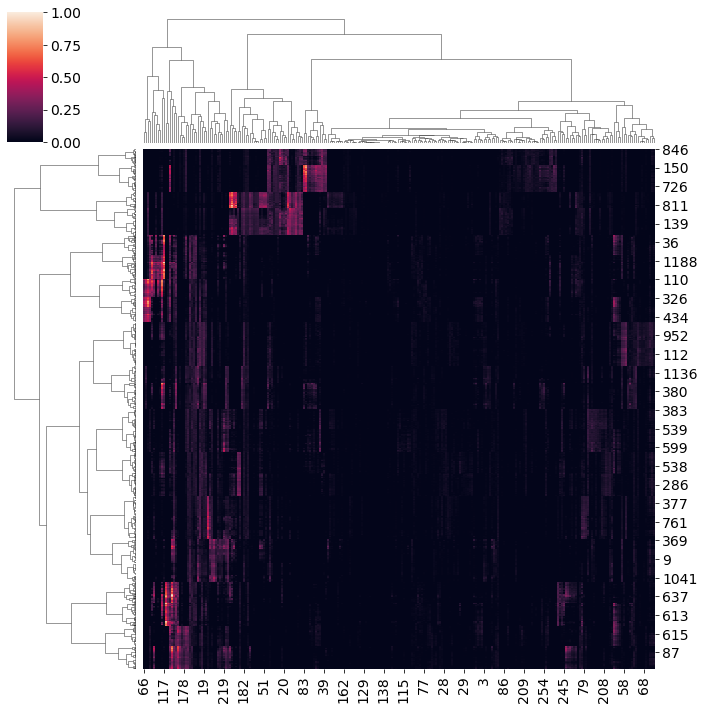

In [33]:
cg = sns.clustermap(X.T, method="ward")
plt.savefig("Clusters.png", dpi=1000)
# [int(el.get_text()) for el in cg.ax_heatmap.get_xticklabels()]

In [171]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

row_linkage = hierarchy.linkage(distance.pdist(X), method="centroid")
print(np.round(row_linkage)[:, 0])

[ 46. 205. 248. 161. 224. 114.  27. 261.  96. 159. 162.  35. 190.  86.
   2. 118.  83. 130.  54. 183.   6.   0.  34.  39.  91. 209.  31.  25.
 108.  43. 281. 137. 124. 177. 274.  75.  37.  69. 126. 277.  44. 134.
 144.  28. 154.  99. 123. 297. 216. 170. 300. 291. 142. 189. 132. 150.
  15. 299. 310. 119. 109.  81. 314.  11.  80.  70.  65. 242.  19. 319.
  49. 112. 326.  51. 155.  21. 168. 311. 228.  68. 152.  94.  84. 322.
 330. 117.  85.  32. 157. 237. 227.  77. 187.  24. 158. 320.  13. 115.
 207.  20. 351.  87.  30. 341. 230. 312.  72. 356.  14.  47. 363. 113.
  78. 366. 235. 233. 200.   8.   9.  60. 236.  18.   1.  82. 153. 143.
 208.  45. 211. 375. 382. 116. 128. 383. 106. 173. 389. 362. 377. 220.
  89. 166.  38. 343.  23. 121. 238.   7. 244. 111. 239. 378.  17. 396.
  36. 243.  66. 336.  74. 409. 212. 254. 103. 131. 140. 415. 129. 101.
 135. 400. 416.  71. 160. 412. 148.   3.  95. 194.  40.  88.  97.  26.
  29.  10. 206.  33. 219. 127. 167. 441. 429. 174. 422. 442.   4. 430.
 437. 

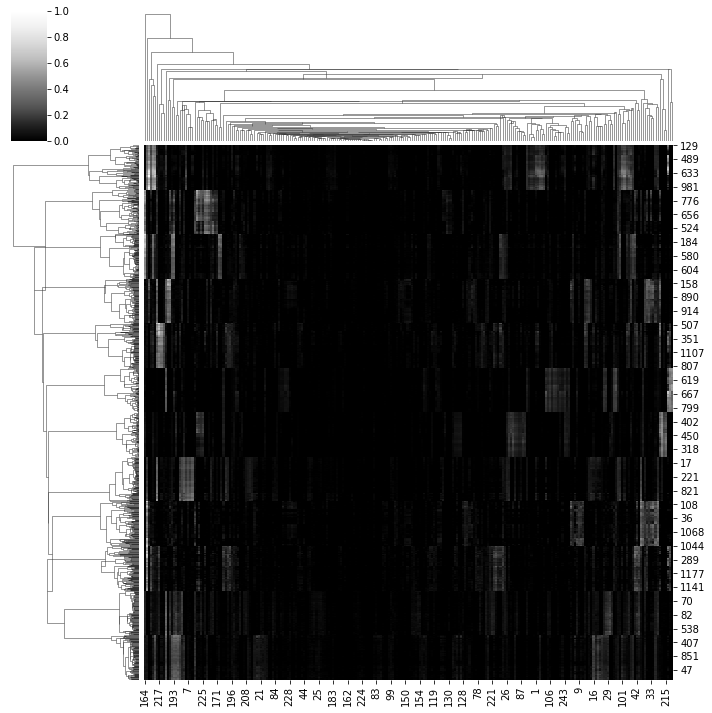

In [154]:
cg = sns.clustermap(X.T, cmap="Greys_r", method="median")

In [148]:
sorted_tasks = sorted(tasks)
[sorted_tasks[int(el.get_text())] for el in cg.ax_heatmap.get_yticklabels()]

IndexError: list index out of range

In [125]:
t = cg.ax_heatmap.get_yticklabels()[0]

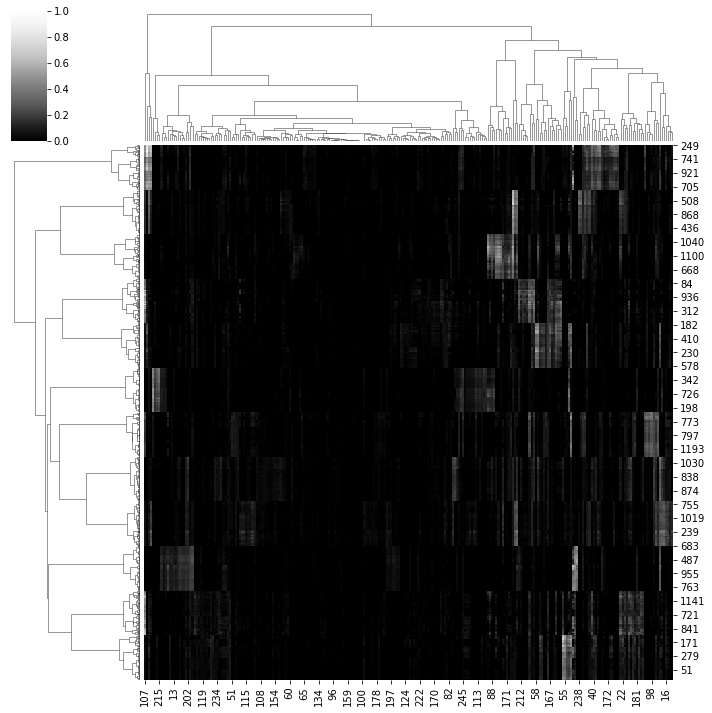

In [146]:
X.shape